### 10x file preprocessing

This notebook was used to create the 10x dataset used in tutorial 03_training_prediciton. Initial files can be downloaded from the 10x website (https://www.10xgenomics.com/resources/datasets under and the keywords "a new way immune profiling"). It is also an updated form of a notebook from our reproducibility repository of which the resulting dataset was used for the publication (https://github.com/SchubertLab/mvTCR_reproducibility/blob/master/preprocessing/10x_preprocessing.ipynb)

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os 
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import scirpy as ir
import anndata as ann
import awkward as ak

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors

C:\Users\Jan\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_base = '../mvTCR/data/10x_CD8TC/'
path_merged = path_base + 'merged_tcr_10x.h5ad'
path_filtered = path_base + 'filtered_tcr_10x.h5ad'
path_logged = path_base + 'logged_10x.h5ad'
path_highlyvar = path_base + 'highly_var_5000.h5ad'
path_clean_split = path_base + 'v5_train_val_test.h5ad'
path_supervised = path_base + 'v6_supervised.h5ad'
path_avidity = path_base + 'v7_avidity.h5ad'

In [ ]:
adatas = []
batch_names = []
for i in range(1, 5):
    # Transcriptome data
    file_name = path_base + f'vdj_v1_hs_aggregated_donor{i}_filtered_feature_bc_matrix.h5'
    adata_tmp = sc.read_10x_h5(file_name)
    
    # TCR data
    path_anno = path_base + f'vdj_v1_hs_aggregated_donor{i}_all_contig_annotations.csv'
    adata_tcr = ir.io.read_10x_vdj(path_anno)

    barcode2idx = {barcode: i for i, barcode in enumerate(adata_tcr.obs_names)}
    idx = [barcode2idx.get(barcode) for barcode in adata_tmp.obs_names]
    
    adata_tmp.obsm["airr"] = adata_tcr.obsm["airr"][idx]
    #Remove all cells with no tcr annotation
    adata_tmp = adata_tmp[~ak.is_none(adata_tmp.obsm['airr']).to_numpy()]

    # Binding data
    path_binding = path_base + f'vdj_v1_hs_aggregated_donor{i}_binarized_matrix.csv'
    binarized_matrix = pd.read_csv(path_binding, sep=',', header=0)

    for k in binarized_matrix.columns:
        adata_tmp.obs[k] = None
        adata_tmp.obs.loc[binarized_matrix['barcode'].values, k] = binarized_matrix[k].values
        adata_tmp.obs[k] = adata_tmp.obs[k].astype(str)
    
    adata_tmp.var_names_make_unique()
    adatas.append(adata_tmp)
    batch_names.append(f'donor_{i}')
      
adata = adatas[0].concatenate(adatas[1:], batch_key='donor', batch_categories=batch_names)

for c in adata.obs.columns:
    if c.startswith('CD') or c.startswith('Ig') or c.startswith('HLA'):
        adata.obs[c] = adata.obs[c].astype(str)

sc.write(adata=adata, filename=path_merged)

In [4]:
adata.obs['donor'].value_counts()

donor
donor_2    78331
donor_1    46835
donor_3    37905
donor_4    27354
Name: count, dtype: int64

In [5]:
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log10(adata.obs['n_counts'])

adata.obs['n_genes'] = (adata.X > 0).sum(1)

mt_gene_mask = [gene.startswith('MT-') for gene in adata.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
adata.obs['mt_fraction'] = adata.X[:, mt_gene_index].sum(1) / adata.X.sum(1)

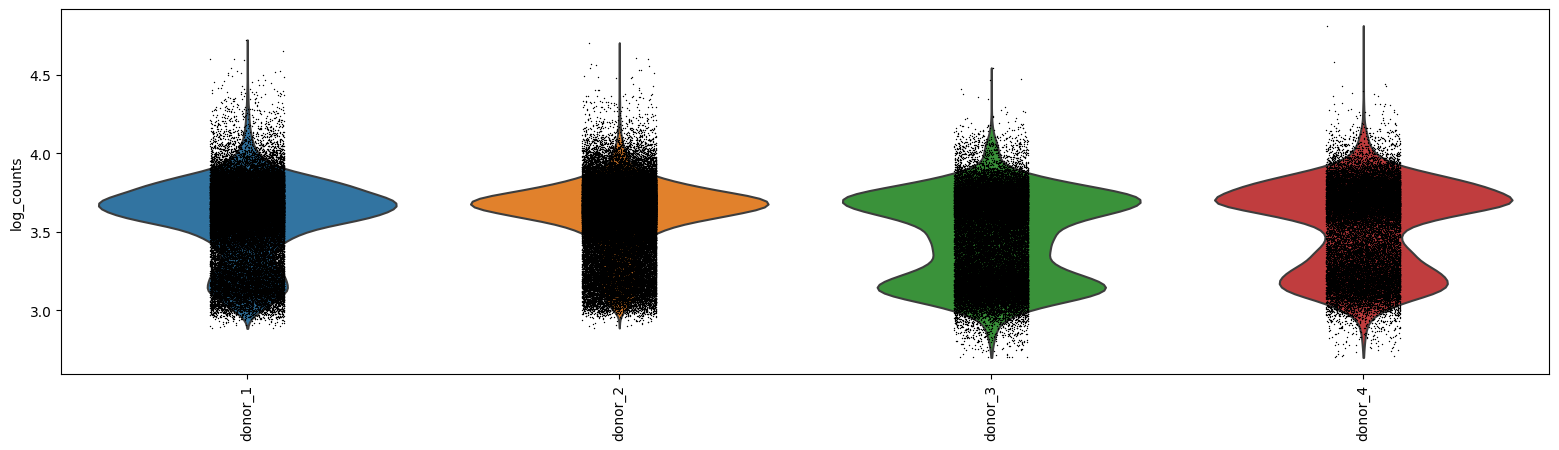

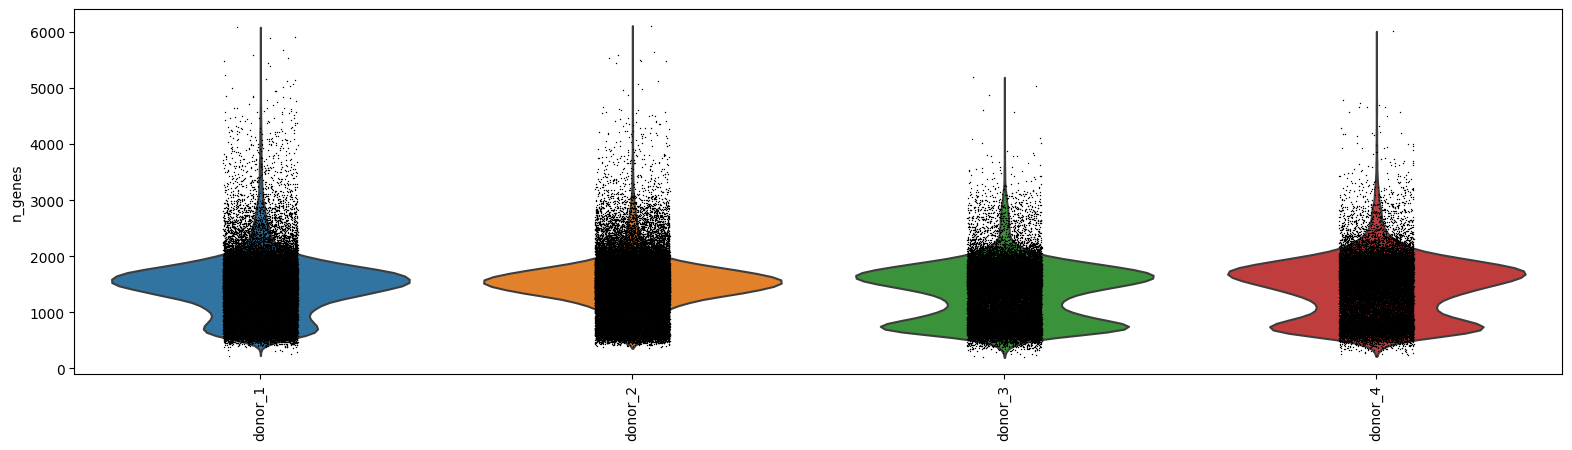

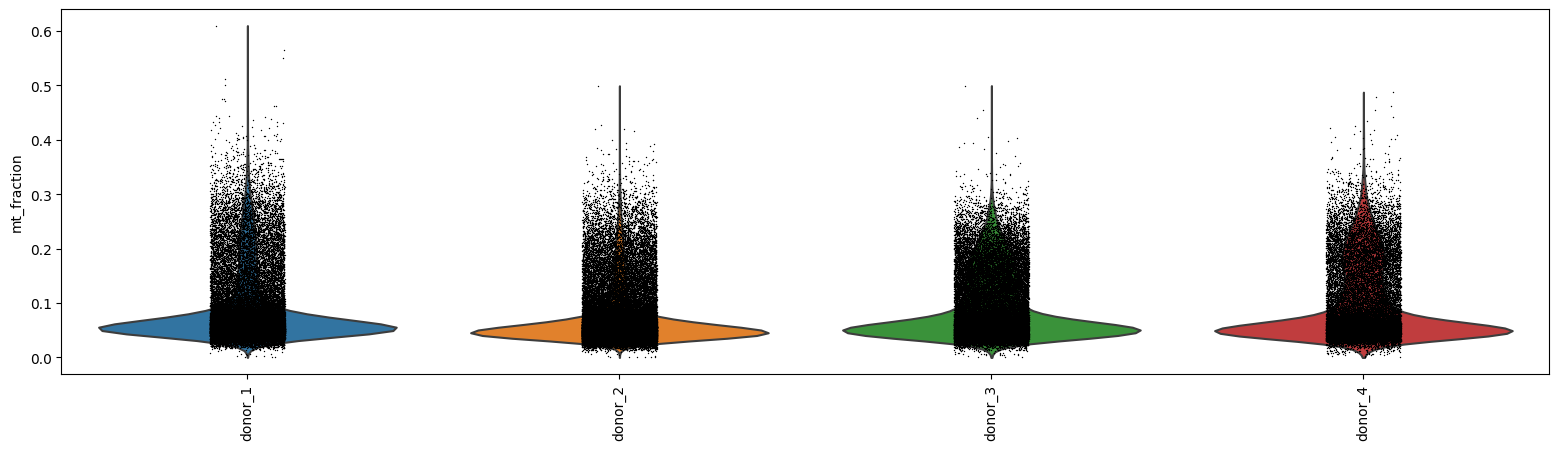

In [6]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata, ['log_counts'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata, ['n_genes'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata, ['mt_fraction'], groupby='donor', size=1, log=False, rotation=90)

<Axes: title={'center': 'mt fraction'}, xlabel='n_counts', ylabel='n_genes'>

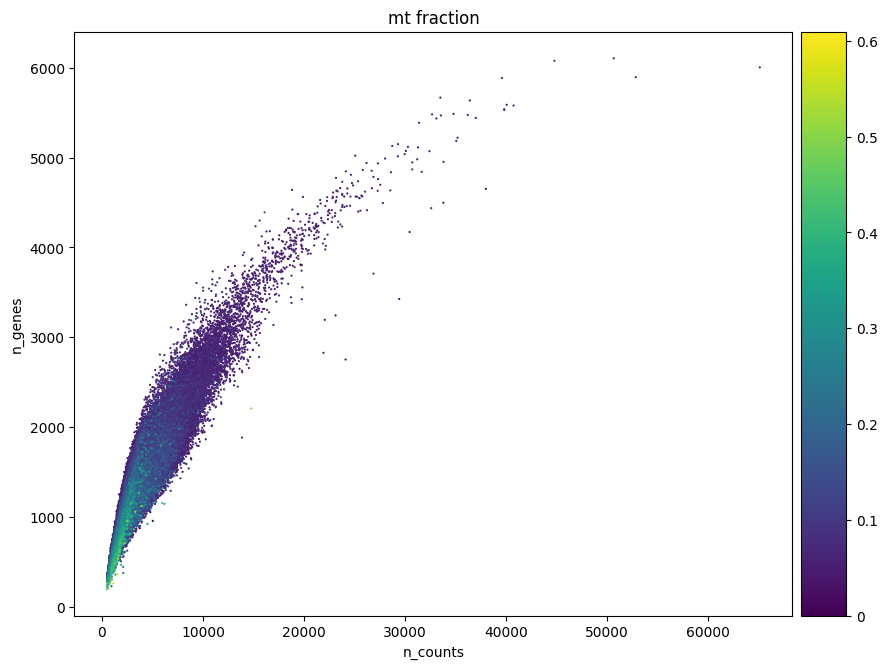

In [7]:
rcParams['figure.figsize'] = (8, 8)
sc.pl.scatter(adata, y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)

<Axes: title={'center': 'donor'}, xlabel='n_counts', ylabel='n_genes'>

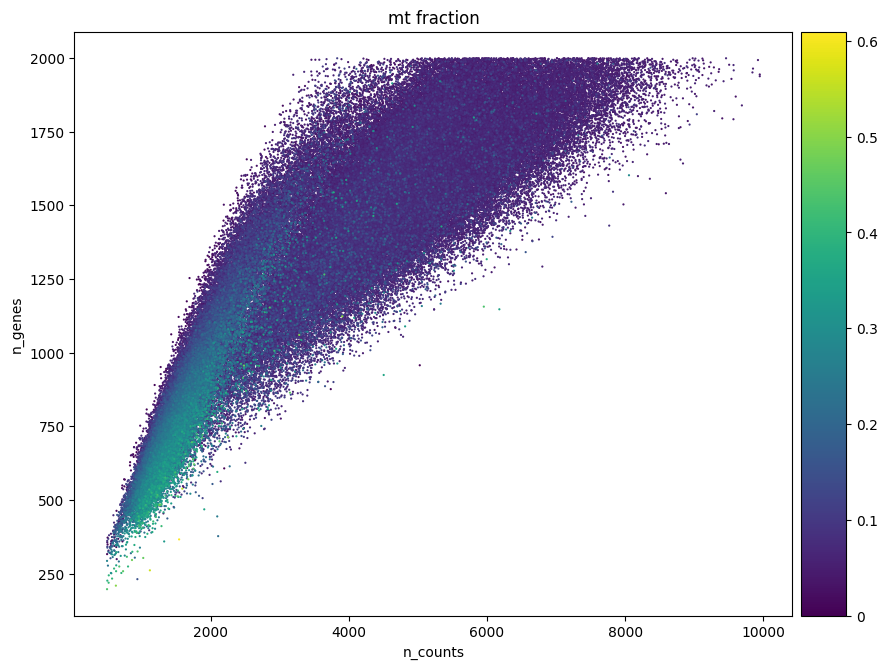

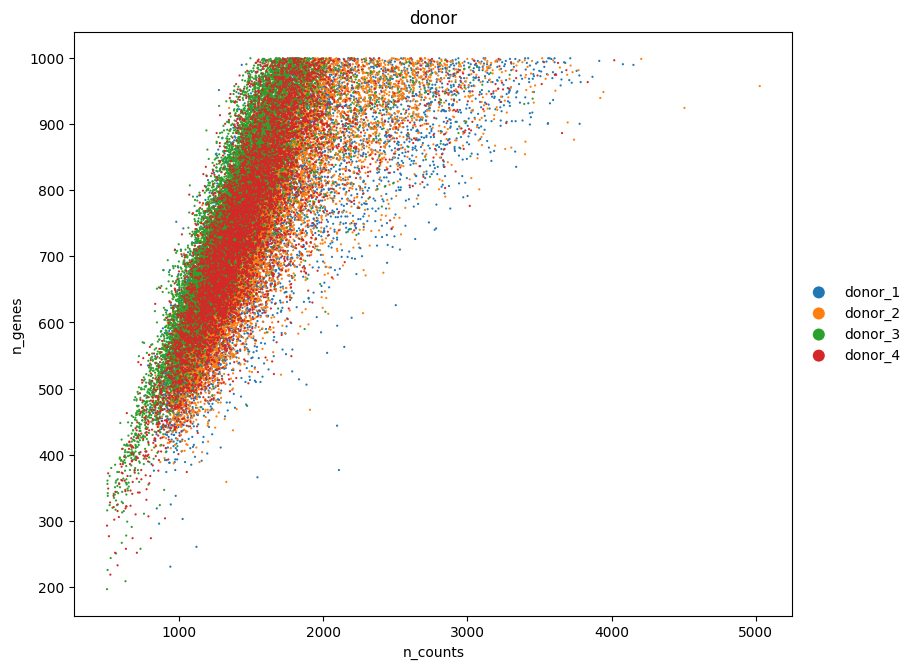

In [8]:
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<2000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='mt_fraction', size=10, show=False)
sc.pl.scatter(adata[np.logical_and(adata.obs['n_genes']<1000, adata.obs['n_counts']<10000)],
             y='n_genes', x='n_counts', color='donor', size=10, show=False)

In [9]:
adata_tmp = adata.copy()
print(f'Total number of cells: {adata_tmp.n_obs}')
high_mt = adata_tmp.obs['mt_fraction'] < 0.2  #todo why this value
adata_tmp = adata_tmp[high_mt]
print(f'Number of cells after MT filter: {adata_tmp.n_obs}')

Total number of cells: 190425
Number of cells after MT filter: 177863


In [10]:
low_count = adata_tmp.obs['n_counts'] > 1000
adata_tmp = adata_tmp[low_count]
print(f'Number of cells after minimum count filter: {adata_tmp.n_obs}')

sc.pp.filter_cells(adata_tmp, max_counts=10000)
print(f'Number of cells after maximum filter: {adata_tmp.n_obs}')

Number of cells after minimum count filter: 176435


C:\Users\Jan\AppData\Roaming\Python\Python311\site-packages\scanpy\preprocessing\_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


Number of cells after maximum filter: 173759


In [11]:
low_genes = adata_tmp.obs['n_genes'] > 500
adata_tmp = adata_tmp[low_genes]
print(f'Number of cells after minimum gene filter: {adata_tmp.n_obs}')

Number of cells after minimum gene filter: 173698


In [12]:
sc.pp.filter_genes(adata_tmp, min_cells=10)
print(f'Number of cells after gene filter: {adata_tmp.n_vars}')

C:\Users\Jan\AppData\Roaming\Python\Python311\site-packages\scanpy\preprocessing\_simple.py:250: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Number of cells after gene filter: 19270


In [13]:
import scrublet as scr
import scipy.io
import time

In [14]:
adata_tmp.obs['doublet_score'] = np.zeros(adata_tmp.shape[0])
adata_tmp.obs['doublet'] = np.zeros(adata_tmp.shape[0])

In [15]:
# filtering / preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 50

# doublet detector parameters
expected_doublet_rate = 0.02
sim_doublet_ratio = 3
n_neighbors = 15

for batch in enumerate(adata_tmp.obs['donor'].cat.categories):
    print(batch)
    t0 = time.time()
    idx = np.flatnonzero(adata_tmp.obs['donor']==batch[1])
    scrub = scr.Scrublet(counts_matrix = adata_tmp[idx, :].X,
                        n_neighbors = n_neighbors,
                        sim_doublet_ratio = sim_doublet_ratio,
                        expected_doublet_rate = expected_doublet_rate)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts = min_counts,
                                                              min_cells = min_cells,
                                                              n_prin_comps = n_pc,
                                                              use_approx_neighbors = True,
                                                              get_doublet_neighbor_parents = False)
    adata_tmp.obs['doublet_score'].iloc[idx] = doublet_scores
    adata_tmp.obs['doublet'].iloc[idx] = predicted_doublets
    t1 = time.time()
    print('Elapsed time: {:.1f} seconds'.format(t1-t0))

(0, 'donor_1')
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 47.7%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 4.1%
Elapsed time: 36.2 seconds
Elapsed time: 37.0 seconds
(1, 'donor_2')


C:\Users\Jan\AppData\Local\Temp\ipykernel_25340\2248260353.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_tmp.obs['doublet_score'].iloc[idx] = doublet_scores
C:\Users\Jan\AppData\Local\Temp\ipykernel_25340\2248260353.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_tmp.obs['doublet'].iloc[idx] = predicted_doublets


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 2.4%
Estimated detectable doublet fraction = 38.2%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 6.3%
Elapsed time: 68.8 seconds
Elapsed time: 70.2 seconds
(2, 'donor_3')


C:\Users\Jan\AppData\Local\Temp\ipykernel_25340\2248260353.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_tmp.obs['doublet_score'].iloc[idx] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 43.5%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 4.2%
Elapsed time: 29.9 seconds
Elapsed time: 30.8 seconds
(3, 'donor_4')


C:\Users\Jan\AppData\Local\Temp\ipykernel_25340\2248260353.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_tmp.obs['doublet_score'].iloc[idx] = doublet_scores


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.14
Detected doublet rate = 1.7%
Estimated detectable doublet fraction = 44.7%
Overall doublet rate:
	Expected   = 2.0%
	Estimated  = 3.8%
Elapsed time: 18.7 seconds
Elapsed time: 19.2 seconds


C:\Users\Jan\AppData\Local\Temp\ipykernel_25340\2248260353.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_tmp.obs['doublet_score'].iloc[idx] = doublet_scores


C:\Users\Jan\AppData\Local\Temp\ipykernel_25340\2925860125.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sb.distplot(adata_tmp.obs['doublet_score'], bins=100, kde=False)


<Axes: xlabel='doublet_score'>

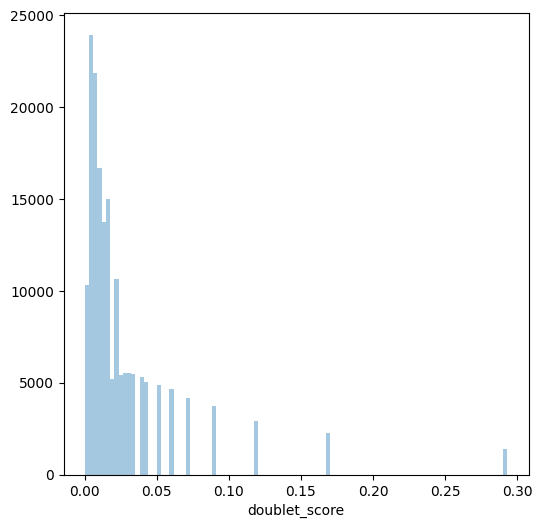

In [16]:
rcParams['figure.figsize'] = (6, 6)
sb.distplot(adata_tmp.obs['doublet_score'], bins=100, kde=False)

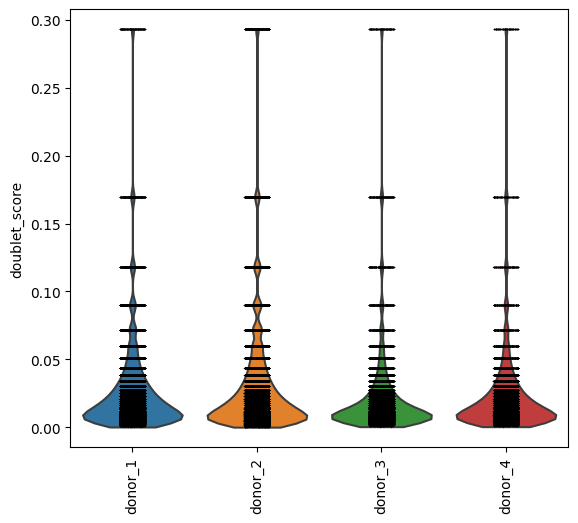

In [17]:
sc.pl.violin(adata_tmp, ['doublet_score'], groupby='donor', size=1, log=False, rotation=90)

In [18]:
thr = 0.05
idx_filter = adata_tmp.obs['doublet_score'] <= thr

adata_tmp = adata_tmp[idx_filter].copy()
print(f'Number of cells after double filter: {adata_tmp.n_obs}')

Number of cells after double filter: 149770


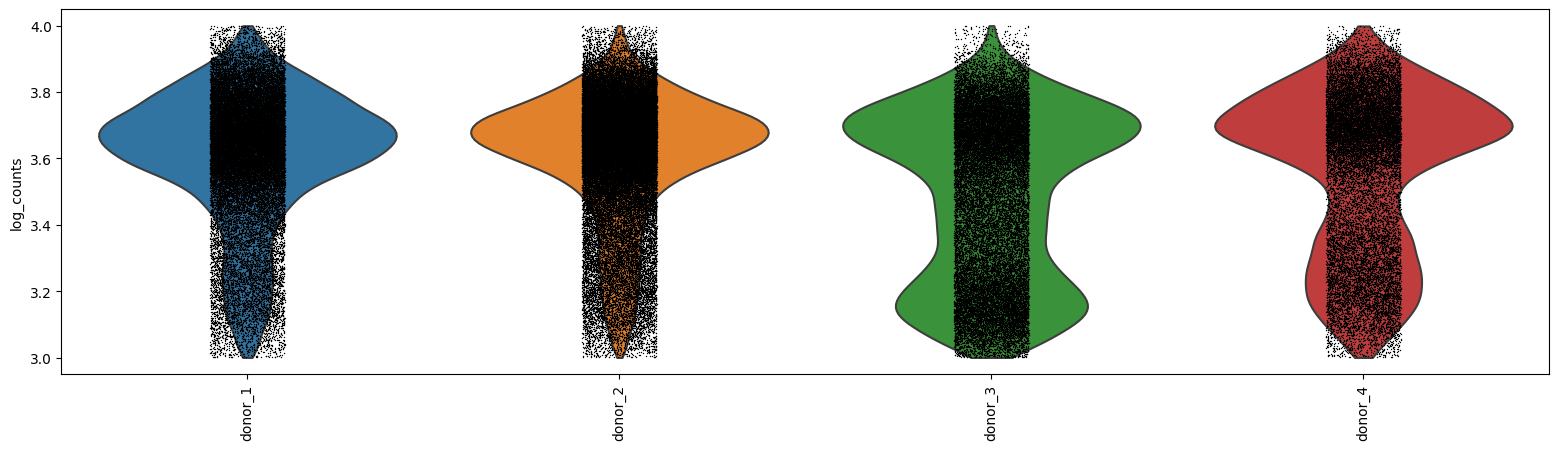

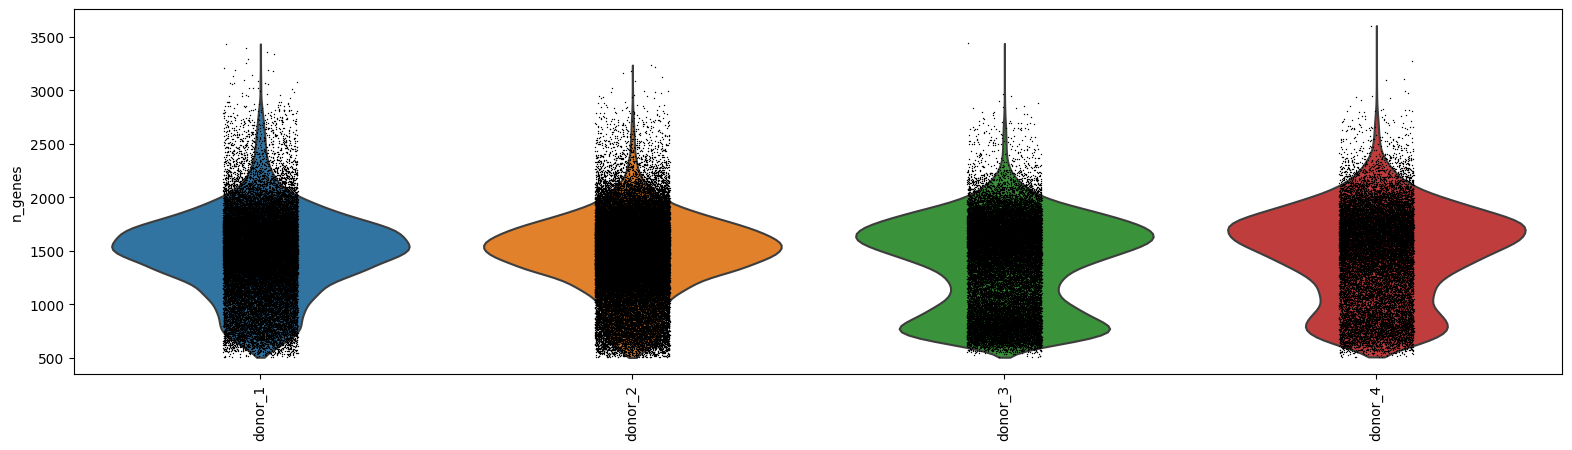

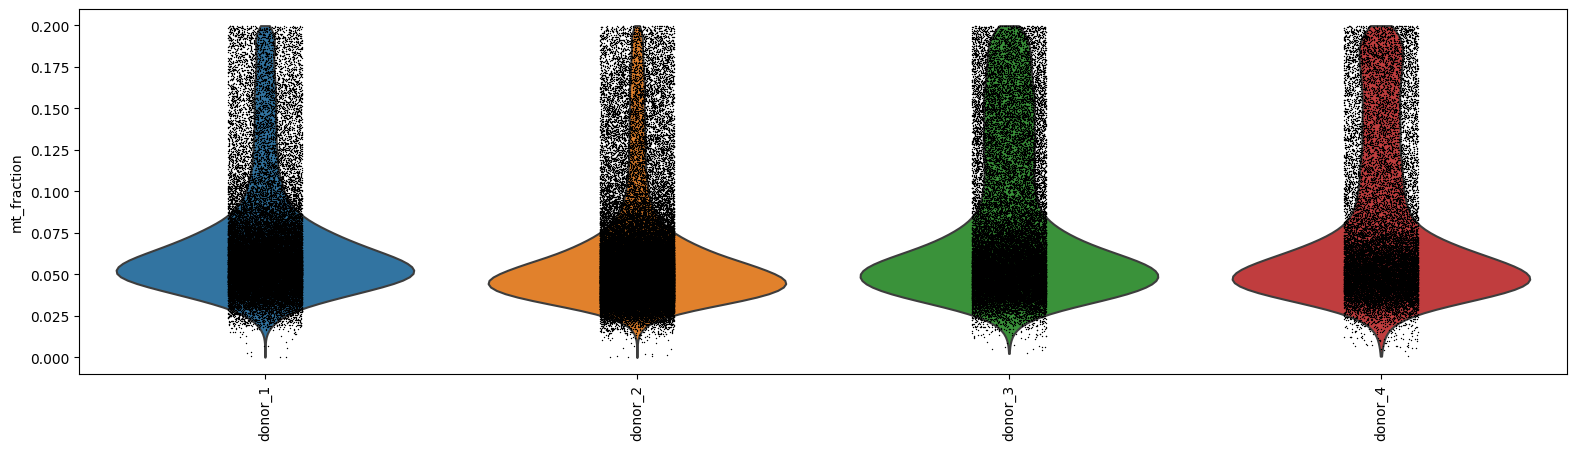

In [19]:
rcParams['figure.figsize'] = (15, 5)
sc.pl.violin(adata_tmp, ['log_counts'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata_tmp, ['n_genes'], groupby='donor', size=1, log=False, rotation=90)
sc.pl.violin(adata_tmp, ['mt_fraction'], groupby='donor', size=1, log=False, rotation=90)

In [20]:
df = adata_tmp.obs[['n_genes', 'n_counts', 'donor']]
df_all = pd.DataFrame(df.groupby(by='donor')['n_genes'].apply(np.mean).values, 
                      index=df.groupby(by='donor')['n_genes'].apply(np.mean).index, 
                      columns=['mean_genes'])

df_all['median_genes'] = df.groupby(by='donor')['n_genes'].apply(np.median).values
df_all['mean_counts'] = df.groupby(by='donor')['n_counts'].apply(np.mean).values
df_all['median_counts'] = df.groupby(by='donor')['n_counts'].apply(np.median).values
df_all

,mean_genes,median_genes,mean_counts,median_counts
donor,,,,
donor_1,1476.094411,1505.0,4434.019043,4413.5
donor_2,1465.885108,1499.0,4409.086426,4487.0
donor_3,1371.821062,1466.0,3593.111572,3562.0
donor_4,1467.303835,1542.0,4181.887207,4395.5


In [21]:
adata_tmp.obs['doublet'] = adata_tmp.obs['doublet'].astype(str)

In [22]:
sc.write(adata=adata_tmp, filename=path_filtered)

In [23]:
sc.pp.normalize_total(adata_tmp, target_sum=1e4)  # target sum? 
sc.pp.log1p(adata_tmp)

In [24]:
sc.write(adata=adata_tmp, filename=path_logged)

In [25]:
adata_tmp.uns['log1p'] = {'base': None}
sc.pp.highly_variable_genes(adata_tmp, n_top_genes=5000, batch_key='donor')
print('Shape before: ', adata_tmp.shape)
adata = adata_tmp[:, adata_tmp.var['highly_variable']]
print('Shape after:  ', adata.shape)

Shape before:  (149770, 19270)
Shape after:  (149770, 19270)


In [26]:
sc.write(adata=adata, filename=path_highlyvar)

In [39]:
#adata = sc.read_h5ad(path_highlyvar)

In [27]:
#TODO loss of info in obsm, only saving airr?
junction_aa = ir.get.airr(adata, "junction_aa")
cells_with_both_chains = ~(junction_aa['VJ_1_junction_aa'].isna() | junction_aa['VDJ_1_junction_aa'].isna())
obms_airr_tmp = adata.obsm['airr'][cells_with_both_chains]

100%|██████████| 30/30 [02:33<00:00,  5.12s/it]


In [143]:
#adata.obsm = None

In [28]:
print(adata.shape)
adata = adata[cells_with_both_chains]
print(adata.shape)

(149770, 5000)
(126129, 5000)


In [ ]:
#adata.obsm['airr'] = obms_airr_tmp

In [29]:
import sys
sys.path.append('../mvTCR')

from tcr_embedding.utils_preprocessing import Preprocessing

In [30]:
Preprocessing.check_if_valid_adata(adata)

True

In [31]:
Preprocessing.encode_clonotypes(adata)

100%|██████████| 50685/50685 [00:55<00:00, 914.60it/s] 


In [32]:
Preprocessing.encode_tcr(adata=adata, airr_name='junction_aa', 
               alpha_label_key='alpha_seq', alpha_length_key='alpha_len',
               beta_label_key='beta_seq', beta_length_key='beta_len')

In [33]:
antigen_binding_list = [x for x in adata.obs.columns if x.endswith('_binder')]
len(antigen_binding_list)

50

In [34]:
binding_matrix = (adata.obs[antigen_binding_list] == 'True').values.astype(int)
binding_matrix.shape

(126129, 50)

In [35]:
unique_value, count = np.unique(binding_matrix.sum(axis=1), return_counts=True)
for unique_value_, count_ in zip(unique_value, count):
    print(f'Cells with {unique_value_} bindings: {count_}')

Cells with 0 bindings: 65411
Cells with 1 bindings: 60718


In [36]:
label_to_binding = {label_id: antigen for label_id, antigen in enumerate(antigen_binding_list)}
label_to_binding[-1] = 'no_data'  # For cells without binding data
binding_to_label = {antigen: label_id for label_id, antigen in enumerate(antigen_binding_list)}
binding_to_label['no_data'] = -1
binding_to_label == {v: k for k, v in label_to_binding.items()}  # sanity check, if both dicts are the reverse of each other

True

In [37]:
adata.obs['has_binding'] = binding_matrix.sum(axis=1).astype(bool)
adata.obs['has_binding'].head()

AAACGGGAGAAGATTC-1-donor_1     True
AAACGGGTCGGACAAG-1-donor_1    False
AAAGATGGTACAGACG-1-donor_1    False
AAAGTAGAGACGCTTT-1-donor_1    False
AAAGTAGAGCGCTTAT-1-donor_1    False
Name: has_binding, dtype: bool

In [38]:
adata.obs['binding_label'] = np.argmax(binding_matrix, axis=1)
adata.obs['binding_label'][~adata.obs['has_binding']] = -1
adata.obs['binding_label'].head()

AAACGGGAGAAGATTC-1-donor_1    29
AAACGGGTCGGACAAG-1-donor_1    -1
AAAGATGGTACAGACG-1-donor_1    -1
AAAGTAGAGACGCTTT-1-donor_1    -1
AAAGTAGAGCGCTTAT-1-donor_1    -1
Name: binding_label, dtype: int64

In [39]:
adata.obs['binding_name'] = adata.obs['binding_label'].map(label_to_binding)
adata.obs['binding_name'].head()

AAACGGGAGAAGATTC-1-donor_1    A0301_KLGGALQAK_IE-1_CMV_binder
AAACGGGTCGGACAAG-1-donor_1                            no_data
AAAGATGGTACAGACG-1-donor_1                            no_data
AAAGTAGAGACGCTTT-1-donor_1                            no_data
AAAGTAGAGCGCTTAT-1-donor_1                            no_data
Name: binding_name, dtype: object

In [40]:
adata.obs['donor+binding'] = adata.obs['donor'].astype(str) + '_' + adata.obs['binding_name'].astype(str)
adata.obs['donor+binding'].sample(10)

GGGCACTCACTCGACG-16-donor_2            donor_2_B0801_RAKFKQLL_BZLF1_EBV_binder
CTGTGCTCACGTCTCT-14-donor_2            donor_2_B0801_RAKFKQLL_BZLF1_EBV_binder
TACCTTACATGGATGG-1-donor_4                                     donor_4_no_data
CACCACTCATTGCGGC-31-donor_2                                    donor_2_no_data
CGAACATGTTCGCTAA-37-donor_1    donor_1_A0201_GILGFVFTL_Flu-MP_Influenza_binder
TAGAGCTTCGCACTCT-28-donor_1                                    donor_1_no_data
ATTCTACCAGTCGATT-18-donor_2            donor_2_B0801_RAKFKQLL_BZLF1_EBV_binder
GATTCAGAGTGTGAAT-29-donor_2                                    donor_2_no_data
GTGCGGTAGCCGATTT-6-donor_4                                     donor_4_no_data
TGGGCGTTCTAACTGG-34-donor_2            donor_2_B0801_RAKFKQLL_BZLF1_EBV_binder
Name: donor+binding, dtype: object

In [41]:
random_seed = 15
# Create Train-Val and Test set
train_val, test = Preprocessing.stratified_group_shuffle_split(adata.obs, stratify_col='donor+binding', group_col='clonotype', val_split=0.20, random_seed=random_seed)
# Split Train-Val into Train and Val set
train, val = Preprocessing.stratified_group_shuffle_split(train_val, stratify_col='donor+binding', group_col='clonotype', val_split=0.25, random_seed=random_seed)

  0%|          | 0/109 [00:00<?, ?it/s]

100%|██████████| 108/108 [00:00<00:00, 189.81it/s]


In [42]:
print('Train Samples: ', len(train))
print('Train Ratio: ', len(train) / len(adata.obs))
print('Val Samples: ', len(val))
print('Val Ratio: ', len(val) / len(adata.obs))
print('Test Samples: ', len(test))
print('Test Ratio: ', len(test) / len(adata.obs))

Train Samples:  82667
Train Ratio:  0.6554162801576164
Val Samples:  20353
Val Ratio:  0.16136653743389703
Test Samples:  23109
Test Ratio:  0.18321718240848656


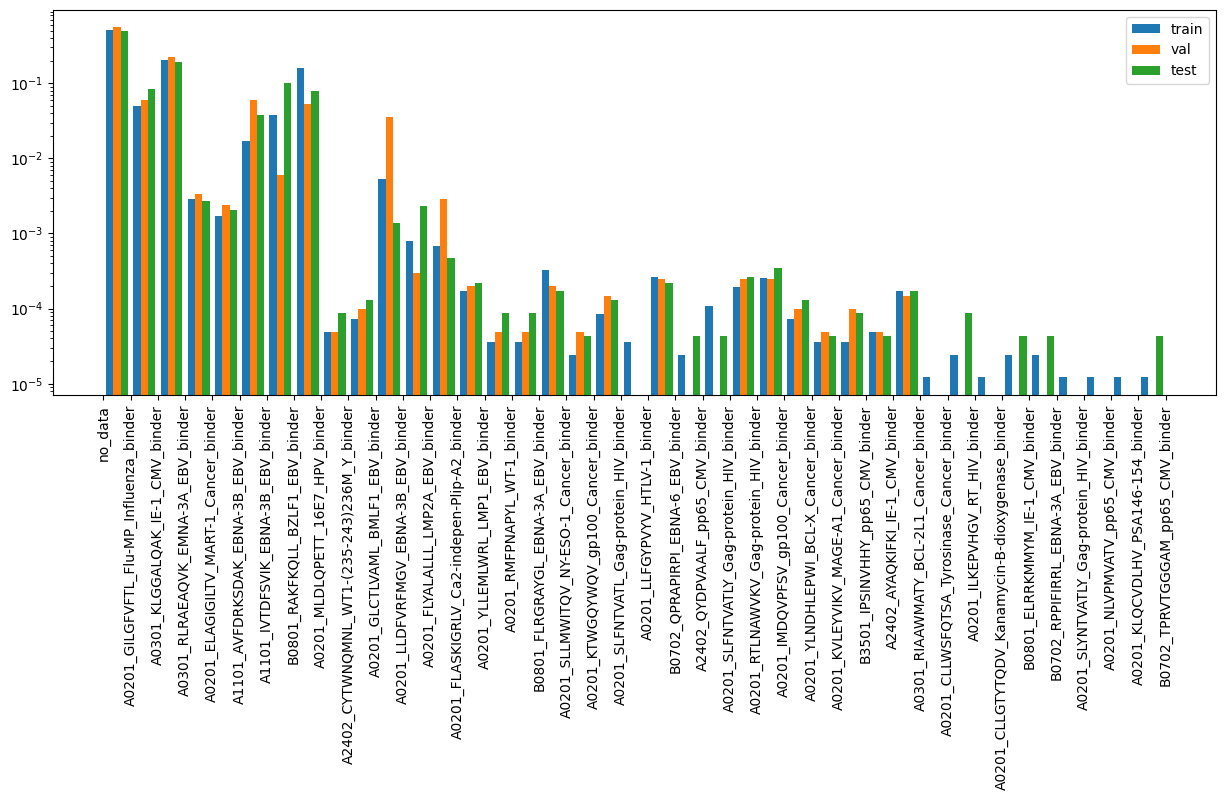

In [43]:
pl.figure(figsize=(15,5))
pl.hist([train['binding_name'], val['binding_name'], test['binding_name']], density=True, bins=len(train['binding_name'].unique()), label=['train', 'val', 'test'])
pl.yscale('log')
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

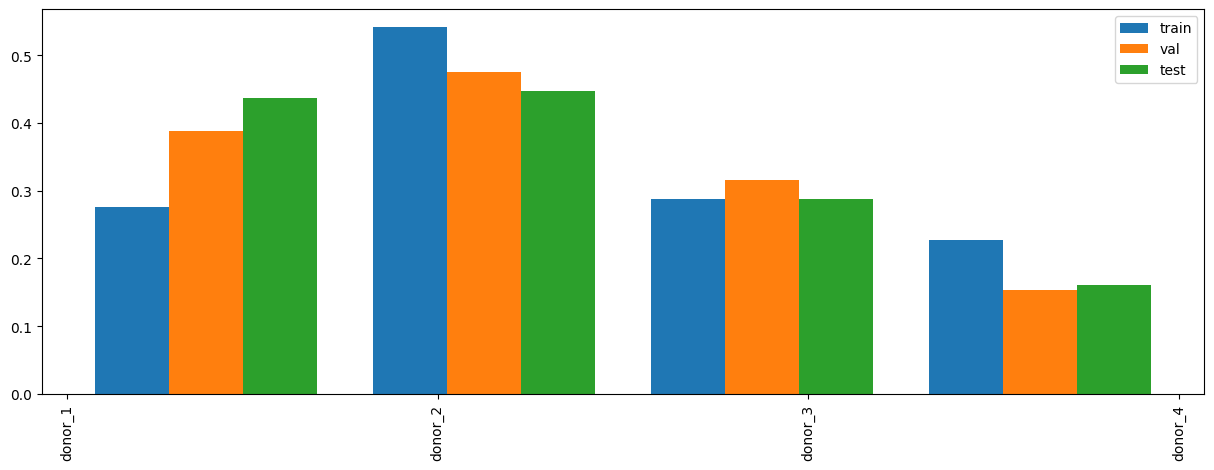

In [44]:
pl.figure(figsize=(15,5))
pl.hist([train['donor'], val['donor'], test['donor']], density=True, bins=len(train['donor'].unique()), label=['train', 'val', 'test'])
pl.xticks(rotation='vertical')
pl.legend(loc='upper right')
pl.show()

In [45]:
form_train = set(train['clonotype'].tolist())
form_val = set(val['clonotype'].tolist())
form_test = set(test['clonotype'].tolist())

print('Intersection in clonotypes between two sets should be empty\n')
print('Intersection in clonotypes between train and test: ', form_train.intersection(form_test))
print('Intersection in clonotypes between train and val: ', form_train.intersection(form_val))
print('Intersection in clonotypes between val and test: ', form_val.intersection(form_test))
# print('\nSanity Check - Intersection in clonotypes between train and train: ', form_train.intersection(form_train))

Intersection in clonotypes between two sets should be empty

Intersection in clonotypes between train and test:  set()
Intersection in clonotypes between train and val:  set()
Intersection in clonotypes between val and test:  set()


In [46]:
adata.obs.loc[train.index, 'set'] = 'train'
adata.obs.loc[val.index, 'set'] = 'val'
adata.obs.loc[test.index, 'set'] = 'test'
adata.obs['set'].value_counts()

set
train    82667
test     23109
val      20353
Name: count, dtype: int64

In [47]:
adata.obs['set'].sample(20)

TGACTAGGTCTTGCGG-3-donor_4     train
GGAAAGCGTGTGTGCC-6-donor_3       val
GAGCAGACATTTGCTT-6-donor_3     train
GACCTGGAGTGGAGAA-29-donor_2     test
TCTCTAACATGCCACG-38-donor_1     test
GACGCGTCAAAGGAAG-40-donor_2     test
GATGAGGAGTTTAGGA-34-donor_2    train
TTTGCGCCATCCGGGT-5-donor_2     train
CGGACGTTCCTAGGGC-40-donor_1    train
CGTGAGCTCCAGTATG-35-donor_2    train
CACACCTTCCAGGGCT-37-donor_2    train
TGCCAAACAACGATCT-9-donor_3      test
CGATTGAAGAGTGAGA-4-donor_3     train
CCTCTGAAGAACAATC-12-donor_3    train
AGCCTAAAGTCGTACT-8-donor_3       val
GTATTCTGTAAGAGGA-7-donor_3      test
CGTAGGCTCGTTTATC-10-donor_2    train
GATCAGTGTCCAGTGC-5-donor_4     train
AAAGCAAAGGCAAAGA-39-donor_2     test
GATGAAAGTGATGCCC-17-donor_1    train
Name: set, dtype: object

In [48]:
adata.write_h5ad(path_clean_split, compression='gzip')

In [146]:
adata = sc.read(path_clean_split)

In [147]:
Preprocessing.check_if_valid_adata(adata)

True

In [148]:
adata.obs[['binding_name', 'binding_label']]

,binding_name,binding_label
AAACGGGAGAAGATTC-1-donor_1,A0301_KLGGALQAK_IE-1_CMV_binder,29
AAACGGGTCGGACAAG-1-donor_1,no_data,-1
AAAGATGGTACAGACG-1-donor_1,no_data,-1
AAAGTAGAGACGCTTT-1-donor_1,no_data,-1
AAAGTAGAGCGCTTAT-1-donor_1,no_data,-1
...,...,...
TTTGTCACATCAGTAC-8-donor_4,no_data,-1
TTTGTCAGTCTAAACC-8-donor_4,no_data,-1
TTTGTCAGTCTCTCGT-8-donor_4,no_data,-1
TTTGTCATCCCACTTG-8-donor_4,no_data,-1


In [149]:
import config.constants_10x as constants
high_count_antigens = constants.HIGH_COUNT_ANTIGENS.copy()
high_count_antigens

['A0201_ELAGIGILTV_MART-1_Cancer_binder',
 'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
 'A0201_GLCTLVAML_BMLF1_EBV_binder',
 'A0301_KLGGALQAK_IE-1_CMV_binder',
 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
 'B0801_RAKFKQLL_BZLF1_EBV_binder']

In [150]:
adata.obs['high_count_binding_name'] = adata.obs['binding_name']
# Set rare antigen specificities to 'no_data'
adata.obs['high_count_binding_name'][~adata.obs['high_count_binding_name'].isin(high_count_antigens)] = 'no_data'
adata.obs['high_count_binding_name'] = adata.obs['high_count_binding_name'].astype(str)
adata.obs['high_count_binding_name'].unique()

array(['A0301_KLGGALQAK_IE-1_CMV_binder', 'no_data',
       'A1101_IVTDFSVIK_EBNA-3B_EBV_binder',
       'A0201_GILGFVFTL_Flu-MP_Influenza_binder',
       'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder',
       'A0301_RLRAEAQVK_EMNA-3A_EBV_binder',
       'A0201_ELAGIGILTV_MART-1_Cancer_binder',
       'B0801_RAKFKQLL_BZLF1_EBV_binder',
       'A0201_GLCTLVAML_BMLF1_EBV_binder'], dtype=object)

In [151]:
# Use this high_count_antigens list to be consistent with the order (alphabetical)
high_count_antigens += ['no_data']
specificity_to_label = {k: v for v, k in enumerate(high_count_antigens)}
label_to_specificity = {str(k): v for k, v in enumerate(high_count_antigens)}
adata.uns['specificity_to_label'] = specificity_to_label
adata.uns['label_to_specificity'] = label_to_specificity
specificity_to_label

{'A0201_ELAGIGILTV_MART-1_Cancer_binder': 0,
 'A0201_GILGFVFTL_Flu-MP_Influenza_binder': 1,
 'A0201_GLCTLVAML_BMLF1_EBV_binder': 2,
 'A0301_KLGGALQAK_IE-1_CMV_binder': 3,
 'A0301_RLRAEAQVK_EMNA-3A_EBV_binder': 4,
 'A1101_IVTDFSVIK_EBNA-3B_EBV_binder': 5,
 'A1101_AVFDRKSDAK_EBNA-3B_EBV_binder': 6,
 'B0801_RAKFKQLL_BZLF1_EBV_binder': 7,
 'no_data': 8}

In [152]:
adata.obs['high_count_binding_label'] = adata.obs['high_count_binding_name'].map(specificity_to_label)
adata.obs['high_count_binding_label'].value_counts()

high_count_binding_label
8    65942
3    25926
7    16030
1     7290
5     5643
6     3497
2     1193
4      370
0      238
Name: count, dtype: int64

In [153]:
adata.obs['high_count_binding_label']

AAACGGGAGAAGATTC-1-donor_1    3
AAACGGGTCGGACAAG-1-donor_1    8
AAAGATGGTACAGACG-1-donor_1    8
AAAGTAGAGACGCTTT-1-donor_1    8
AAAGTAGAGCGCTTAT-1-donor_1    8
                             ..
TTTGTCACATCAGTAC-8-donor_4    8
TTTGTCAGTCTAAACC-8-donor_4    8
TTTGTCAGTCTCTCGT-8-donor_4    8
TTTGTCATCCCACTTG-8-donor_4    8
TTTGTCATCTCTAAGG-8-donor_4    8
Name: high_count_binding_label, Length: 126129, dtype: int64

In [154]:
sc.write(adata=adata, filename=path_supervised)

In [155]:
Preprocessing.check_if_valid_adata(adata)

True

In [156]:
cols_binder_counts = constants.HIGH_COUNT_ANTIGENS
cols_binder_counts = ['_'.join(el.split('_')[:-1]) for el in cols_binder_counts]

In [157]:
binding_counts = []
for donor in range(1, 5):
    path_binding = path_base + f'vdj_v1_hs_aggregated_donor{donor}_binarized_matrix.csv'
    binarized_matrix = pd.read_csv(path_binding, sep=',', header=0, index_col=0)
    binarized_matrix.index.name = None
    binarized_matrix = binarized_matrix[cols_binder_counts]
    binarized_matrix.index = binarized_matrix.index + f'-donor_{donor}'
    binding_counts.append(binarized_matrix)
binding_counts = pd.concat(binding_counts)

In [158]:
binding_counts = binding_counts.loc[adata.obs.index]
adata.obsm['binding_counts'] = binding_counts.values

In [159]:
adata.obsm['binding_counts']

array([[ 0.,  0.,  0., ..., 10.,  9.,  0.],
       [ 0.,  0.,  0., ...,  2.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  2.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.]])

In [160]:
sc.write(adata=adata, filename=path_avidity)